In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/project 1

/content/drive/MyDrive/project 1


In [3]:
%pwd

'/content/drive/MyDrive/project 1'

In [4]:
%pip install import-ipynb
%pip install ptflops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.6 MB/s eta 0:00:00


### Task 1

#### 1. Basic Concepts
1. The purpose of using dataset distillation in this paper is to reduce the training costs while maintaining the high performance on various machine learning tasks. The authors introduce Dataset Distillation with Attention Maching (DataDAM) to condense large datasets into smaller synthetic dataset that retain the critical information, allowing models trained on the synthetic set to achieve similar accuracy as those trained on the full dataset.
2.  The advantages are: (page 2)
- Efficient end-to-end dataset distillation: This highlights the ability of DataDAM to closely approximate the distribution of the real dataset while keeping **computational costs low**.
- Improved accuracy and scalability: DataDAM demonstrate the performance across multiple benchmark dataset and reduces the training costs by up to 100x, while also allowing for cross-architecture generation. This makes it more scalable and flexible for real-world application.
- Enhancement of downstream application: DATADAM's distilled data improves memory efficiency in continual learning tasks and accelerates neural architectures search(NAS) by providing a more representative proxy dataset, enabling a faster and more efficient learning process.  
3. The novelty includes: (page 2)
- Multiple Randomly Initialized DNNs: DataDAM uses multiple randomly initialized deep neural networks to extract meaningful representations from both real and synthetic datasets, which is different from methods that rely on pre-trained models
- Spatial attention matching (SAM): The SAM module align the most discriminative feature maps from real and synthetic datasets, reducing the gap between the dataset.
- Last-Layer Feature Alignment: It reduces disparities in the last-layer feature distributions between the real and synthetic datasets by using a complementary loss as a regularizer, ensuring high-level abstract representations are similar.
- Bias-Free Synthetic Data: The synthetic data generated by DataDAM does not introduce any bias, which is a significant improvement over prior methods, ensuring better generalization and performance.
4. The methodology of DataDAM is centered on efficiently distilling datasets through attention matching: (page 4)
- Initialization of Synthetic Dataset: The process starts by initializing a synthetic dataset, which can be done through random noise or by sampling real data.
- Feature Extraction: Real and synthetic datasets are passed through randomly initialized deep neural networks, and features are extracted at multiple layers.
- Spatial Attention Matching (SAM): Attention maps are computed for each layer, excluding the final layer. These attention maps focus on the most discriminative regions of the input image.
- Loss Functions:
    - SAM Loss (LSAM): This loss minimizes the distance between attention maps of real and synthetic datasets across layers.
    - Maximum Mean Discrepancy Loss (MMD): This complementary loss aligns the last-layer feature distributions of the two datasets, ensuring the high-level abstract information is captured.
- Optimization: The synthetic dataset is optimized using a combination of the SAM loss and LMMD loss to minimize the difference between real and synthetic data.
5. (page 8)
- Continual Learning: DataDAM’s ability to condense datasets efficiently makes it highly useful in continual learning scenarios, where a model must learn incrementally while preventing catastrophic forgetting. By using the distilled datasets as a replay buffer, DataDAM can significantly improve memory efficiency and performance in incremental learning tasks.
- Neural Architecture Search (NAS): The synthetic datasets generated by DataDAM can serve as proxies in NAS tasks, allowing faster evaluation of model architectures. This leads to a significant reduction in computational costs and time during the model search process, making NAS more feasible in real-world applications.

#### 2. Data Distillation Learning - MHIST
##### a) Train model with origianl dataset


In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import SGD
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR

In [41]:
import import_ipynb
from utils import get_network, get_time

In [42]:
train_folder = 'mhist_dataset/train'
test_folder = 'mhist_dataset/test'

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [43]:
model = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224))
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, T_max=20)
criterion = torch.nn.CrossEntropyLoss()

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def training_model(model, optimizer, scheduler, criterion, train_loader):
    torch.cuda.empty_cache()
    for epoch in range(20):
        model.train()

        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            labels = labels.long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            torch.cuda.empty_cache()
        scheduler.step()

        print(f"Epoch [{epoch+1}/20], Loss: {running_loss / len(train_loader.dataset)}")


In [47]:
training_model(model, optimizer, scheduler, criterion, train_loader)

Epoch [1/20], Loss: 0.6494806645656455
Epoch [2/20], Loss: 0.6494806639627478
Epoch [3/20], Loss: 0.6494806616059665
Epoch [4/20], Loss: 0.6494806617703931
Epoch [5/20], Loss: 0.6494806662921248
Epoch [6/20], Loss: 0.6494806666483824
Epoch [7/20], Loss: 0.6494806717730116
Epoch [8/20], Loss: 0.6494806683200529
Epoch [9/20], Loss: 0.6494806721566737
Epoch [10/20], Loss: 0.6494806682652441
Epoch [11/20], Loss: 0.6494806723759092
Epoch [12/20], Loss: 0.6494806628939749
Epoch [13/20], Loss: 0.6494806740201753
Epoch [14/20], Loss: 0.6494806618800109
Epoch [15/20], Loss: 0.6494806640175568
Epoch [16/20], Loss: 0.6494806732254467
Epoch [17/20], Loss: 0.6494806686215017
Epoch [18/20], Loss: 0.6494806597150605
Epoch [19/20], Loss: 0.6494806704575988
Epoch [20/20], Loss: 0.6494806701013411


In [48]:
model_path = 'models/mhist_original.pth'
torch.save(model.state_dict(), model_path)

In [49]:
model_path = 'models/mhist_original.pth'
model = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224))
model.load_state_dict(torch.load(model_path))


<ipython-input-49-bfca554a1187>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader):
    model.to(device)
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          labels = labels.long()
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

In [ ]:
evaluate_model(model, test_loader)

Test Accuracy: 81.06%


In [ ]:
from ptflops import get_model_complexity_info

macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
print(f"MACs: {macs}, Parameters: {params}")

ConvNet(
  891.14 k, 100.000% Params, 2.68 GMac, 99.365% MACs, 
  (features): Sequential(
    890.88 k, 99.971% Params, 2.68 GMac, 99.365% MACs, 
    (0): Conv2d(3.58 k, 0.402% Params, 179.83 MMac, 6.664% MACs, 3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm(256, 0.029% Params, 12.85 MMac, 0.476% MACs, 128, 128, eps=1e-05, affine=True)
    (2): ReLU(0, 0.000% Params, 6.42 MMac, 0.238% MACs, inplace=True)
    (3): AvgPool2d(0, 0.000% Params, 6.42 MMac, 0.238% MACs, kernel_size=2, stride=2, padding=0)
    (4): Conv2d(147.58 k, 16.561% Params, 1.85 GMac, 68.604% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GroupNorm(256, 0.029% Params, 3.21 MMac, 0.119% MACs, 128, 128, eps=1e-05, affine=True)
    (6): ReLU(0, 0.000% Params, 1.61 MMac, 0.060% MACs, inplace=True)
    (7): AvgPool2d(0, 0.000% Params, 1.61 MMac, 0.060% MACs, kernel_size=2, stride=2, padding=0)
    (8): Conv2d(147.58 k, 16.561% Params, 462.82 MMac, 17.151% MACs, 128,

In [ ]:
total_flops = 0

for inputs, labels in test_loader:
    total_flops += get_model_complexity_info(model, (3, 224, 224), as_strings=False)[0]

print(f"Total FLOPs for the test dataset: {total_flops}")

ConvNet(
  891.14 k, 100.000% Params, 2.68 GMac, 99.365% MACs, 
  (features): Sequential(
    890.88 k, 99.971% Params, 2.68 GMac, 99.365% MACs, 
    (0): Conv2d(3.58 k, 0.402% Params, 179.83 MMac, 6.664% MACs, 3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm(256, 0.029% Params, 12.85 MMac, 0.476% MACs, 128, 128, eps=1e-05, affine=True)
    (2): ReLU(0, 0.000% Params, 6.42 MMac, 0.238% MACs, inplace=True)
    (3): AvgPool2d(0, 0.000% Params, 6.42 MMac, 0.238% MACs, kernel_size=2, stride=2, padding=0)
    (4): Conv2d(147.58 k, 16.561% Params, 1.85 GMac, 68.604% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GroupNorm(256, 0.029% Params, 3.21 MMac, 0.119% MACs, 128, 128, eps=1e-05, affine=True)
    (6): ReLU(0, 0.000% Params, 1.61 MMac, 0.060% MACs, inplace=True)
    (7): AvgPool2d(0, 0.000% Params, 1.61 MMac, 0.060% MACs, kernel_size=2, stride=2, padding=0)
    (8): Conv2d(147.58 k, 16.561% Params, 462.82 MMac, 17.151% MACs, 128,

##### b) Learn the synthetic dataset with attention matching algorithm

In [51]:
# real dataset loader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
real_dataset = datasets.ImageFolder(root='mhist_dataset/train', transform=transform)
real_loader = torch.utils.data.DataLoader(real_dataset, batch_size=128, shuffle=True)

In [52]:
import torch
import random
from torch import optim

num_classes = 2
num_images_per_class = 50
img_size = (3, 224, 224)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def generate_synthetic_dataset(real_dataset, num_classes=2, images_per_class=50, K=200, eta_s=0.1,
                               zeta_s=1, eta_theta=0.01, zeta_theta=50, minibatch_size=128):
    synthetic_images = []
    synthetic_labels = []

    for class_id in range(num_classes):

        class_indices = [i for i, (_, label) in enumerate(real_dataset) if label == class_id]
        sampled_indices = random.sample(class_indices, images_per_class)

        for i in sampled_indices:
            img_real = real_dataset[i][0].to(device)

            synthetic_versions = []
            for _ in range(K):
                synthetic_image = img_real.clone().detach().requires_grad_(True)
                synthetic_versions.append(synthetic_image)

            for synthetic_image in synthetic_versions:
                optimizer_condensed = optim.SGD([synthetic_image], lr=eta_s)

                for _ in range(zeta_s):
                    optimizer_condensed.zero_grad()
                    loss = torch.nn.functional.mse_loss(synthetic_image, img_real)
                    loss.backward()
                    optimizer_condensed.step()

            final_synthetic_image = torch.mean(torch.stack(synthetic_versions), dim=0).detach()

            synthetic_images.append(final_synthetic_image)
            synthetic_labels.append(class_id)

    img_syn = torch.stack(synthetic_images)
    labels_syn = torch.tensor(synthetic_labels, device=device)

    return img_syn, labels_syn


In [53]:
#step 2: optimizer
img_syn, labels_syn = generate_synthetic_dataset(real_dataset, 2)

img_syn = torch.nn.Parameter(img_syn)
optimizer_img = optim.SGD([img_syn], lr=0.1)  # lr is eta_s

In [54]:
# step 3: set up model - ConvNET - 7 in this case
# freeze the model's weights so that only the synthetic dataset is updated

model_path = 'models/mhist_original.pth'
net = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224))
net.load_state_dict(torch.load(model_path, map_location=device))
net.to(device)
net.train()

for param in list(net.parameters()):
    param.requires_grad = False

<ipython-input-54-2e2ec9446353>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_path, map_location=device))


In [55]:
# step 5: hook
# Using hook to extract the activations from the layers (attention maps) to compare the attention maps from real to synthetic
activations = {}


def get_activation(name):
    def hook_func(m, inp, op):
        activations[name] = op.detach()

    return hook_func


''' Defining the Refresh Function to store Activations and reset Collection '''


def refresh_activations(activations):
    model_set_activations = []  # Jagged Tensor Creation
    for i in activations.keys():
        model_set_activations.append(activations[i])
    activations = {}
    return activations, model_set_activations


def delete_hooks(hooks):
    for i in hooks:
        i.remove()
    return


def attach_hooks(net):
    hooks = []
    for name, module in net.named_modules():
        if isinstance(module, nn.ReLU):
            hooks.append(module.register_forward_hook(get_activation(name)))
    return hooks


In [56]:
# step 6: Attention Matching Map
def get_attention(feature_set, param=0, exp=4, norm='l2'):
    if param == 0:
        attention_map = torch.sum(torch.abs(feature_set), dim=1)

    elif param == 1:
        attention_map = torch.sum(torch.abs(feature_set) ** exp, dim=1)

    elif param == 2:
        attention_map = torch.max(torch.abs(feature_set) ** exp, dim=1)

    if norm == 'l2':
        # Dimension: [B x (H*W)] -- Vectorized
        vectorized_attention_map = attention_map.view(feature_set.size(0), -1)
        normalized_attention_maps = F.normalize(vectorized_attention_map, p=2, dim=1)

    return normalized_attention_maps

In [57]:
# step 7: error function
def error(real, syn, err_type="MSE"):
    if err_type == "MSE":
        err = torch.sum((torch.mean(real, dim=0) - torch.mean(syn, dim=0)) ** 2)
    elif err_type == "MAE":
        err = torch.sum(torch.abs(torch.mean(real, dim=0) - torch.mean(syn, dim=0)))
    elif err_type == "MSE_B":
        err = torch.sum(
            (torch.mean(real.reshape(2, -1).cpu(), dim=1) - torch.mean(syn.reshape(2, -1).cpu(), dim=1)) ** 2)
    else:
        raise ValueError("Invalid error type")
    return err

In [58]:
# step 8: training loop
def train_dataset(img_syn, labels_syn, activations={}):
    num_iterations = 10
    learning_rate_model = 0.01

    losses = []
    for iteration in range(num_iterations):
        print(f"Iteration {iteration + 1}/{num_iterations}")

        images_syn_all = []
        labels_syn_all = []
        images_real_all = []
        labels_real_all = []

        for c in range(num_classes):
            img_real, label_real = next(iter(real_loader))
            img_real = img_real.to(device)
            img_syn_per_class = img_syn[c * num_images_per_class:(c + 1) * num_images_per_class].to(device)
            label_syn_per_class = labels_syn[c * num_images_per_class:(c + 1) * num_images_per_class]

            images_real_all.append(img_real)
            labels_real_all.append(label_real)
            images_syn_all.append(img_syn_per_class)
            labels_syn_all.append(label_syn_per_class)

        images_real_all = torch.cat(images_real_all, dim=0)
        labels_real_all = torch.cat(labels_real_all, dim=0)
        images_syn_all = torch.cat(images_syn_all, dim=0)
        labels_syn_all = torch.cat(labels_syn_all, dim=0)

        net.train()
        hooks = attach_hooks(net)

        output_real = net(images_real_all)[0]
        activations, original_model_set_activations = refresh_activations(activations)

        output_syn = net(images_syn_all)[0]
        activations, syn_model_set_activations = refresh_activations(activations)
        delete_hooks(hooks)

        length_of_network = len(original_model_set_activations)

        loss = torch.tensor(0.0)
        mid_loss = 0
        out_loss = 0
        loss_avg = 0

        for layer in range(length_of_network - 1):
            real_attention = get_attention(original_model_set_activations[layer], param=1, exp=1, norm='l2')
            syn_attention = get_attention(syn_model_set_activations[layer], param=1, exp=1, norm='l2')

            tl = 100 * error(real_attention, syn_attention, err_type="MSE_B")
            loss += tl
            mid_loss += tl.item()

        output_loss = 100 * 0.01 * error(output_real, output_syn, err_type="MSE_B")
        loss += output_loss
        out_loss += output_loss.item()

        optimizer_img.zero_grad()
        loss.backward()
        optimizer_img.step()
        loss_avg += loss.item()
        torch.cuda.empty_cache()

        loss_avg /= (num_classes)
        out_loss /= (num_classes)
        mid_loss /= (num_classes)
        losses.append((loss_avg, out_loss, mid_loss))
        if iteration % 10 == 0:
            print('%s iter = %05d, loss = %.4f' % (get_time(), iteration, loss_avg))

    print("training completed.")
    return img_syn, labels_syn, losses


In [59]:
def save_results(img_syn, labels_syn, losses, noise_type):
    save_path = f"mhist_result/{noise_type}_synthetic_dataset.pt"

    torch.save({'images': img_syn, 'labels': labels_syn}, save_path)

    print(f"Synthetic dataset saved to {save_path}")

    loss_log_path = f"mhist_result/{noise_type}_training_losses.txt"
    with open(loss_log_path, "w") as f:
        for epoch, loss in enumerate(losses):
            f.write(f"Iteration {epoch}: Loss = {loss}\n")

    print(f"Training losses saved to {loss_log_path}")

In [60]:
img_syn, labels_syn, losses = train_dataset(img_syn, labels_syn)
save_results(img_syn, labels_syn, losses, '')

Iteration 1/10
[2024-10-28 21:16:50] iter = 00000, loss = 0.0062
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
training completed.
Synthetic dataset saved to mhist_result/_synthetic_dataset.pt
Training losses saved to mhist_result/_training_losses.txt


##### 2c) Visualize the condensed images per class

In [61]:
import torch
import os
import matplotlib.pyplot as plt

def display_image_grid(img_syn, labels_syn, noise_type):
    # Create directory to save grid images
    save_dir = f"mhist_result/{noise_type}_grid"
    os.makedirs(save_dir, exist_ok=True)

    num_samples_per_class = 50

    class_dict = {}

    for img, label in zip(img_syn, labels_syn):
        label = label.item()
        if label not in class_dict:
            class_dict[label] = []
        class_dict[label].append(img)

    for class_label, images in class_dict.items():
        selected_images = images[:num_samples_per_class]

        fig, axs = plt.subplots(5, 10, figsize=(15, 7))
        fig.suptitle(f"Class {class_label} - {noise_type}", fontsize=16)
        fig.patch.set_facecolor('white')

        # Display each image
        for idx, img in enumerate(selected_images):
            img_np = img.permute(1, 2, 0).detach().numpy()
            axs[idx // 10, idx % 10].imshow(img_np)
            axs[idx // 10, idx % 10].axis('off')
            axs[idx // 10, idx % 10].set_facecolor('white')

        # Display the grid of images
        plt.show()

        # Save the grid of images as a single image file for report
        grid_save_path = os.path.join(save_dir, f"class_{class_label}_grid.png")
        fig.savefig(grid_save_path, facecolor='white')  # Save grid with white background
        plt.close()

    print(f"Image grids saved to {save_dir}")

# Call the function with your loaded data

<ipython-input-62-67b31e4c11b4>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('mhist_result/_synthetic_dataset.pt')


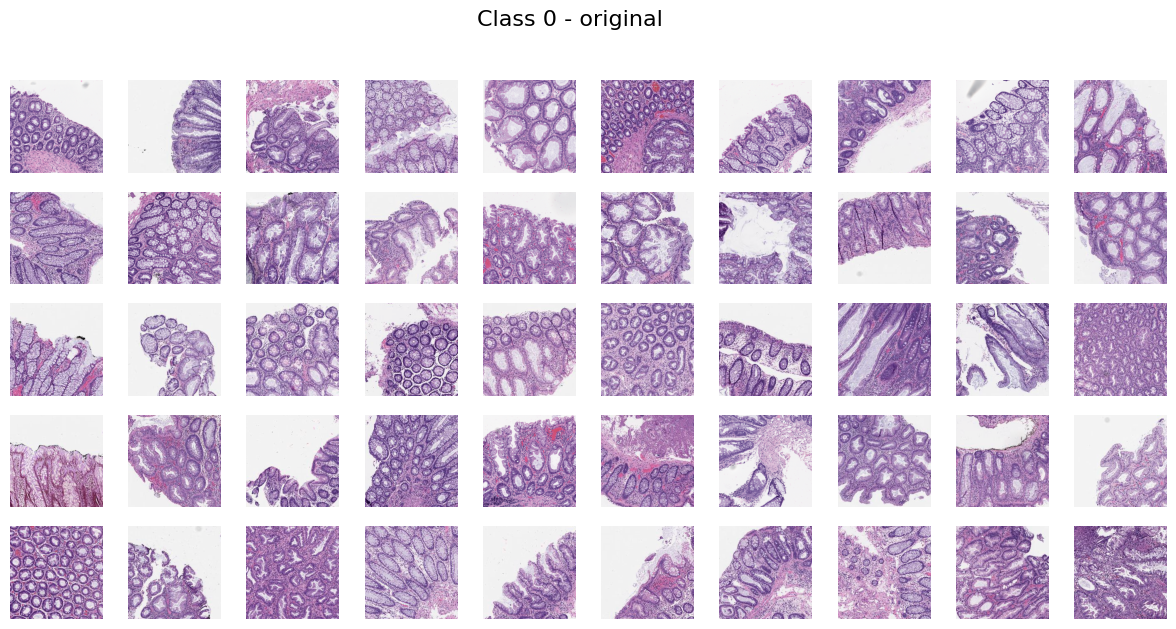

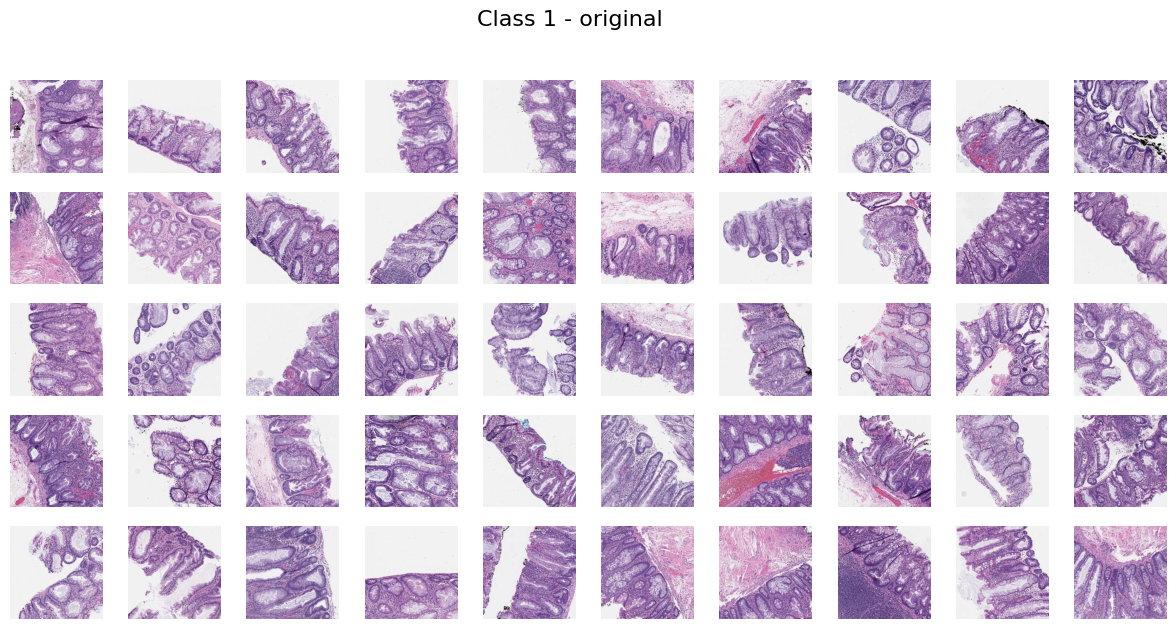

Image grids saved to mhist_result/original_grid


In [62]:
img_syn_loaded = torch.load('mhist_result/_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

display_image_grid(img_syn, labels_syn, noise_type='original')

#### random noise

In [89]:
# set up the synthetic dataset
import random

num_classes = 2
num_images_per_class = 50
img_size = (3, 224, 224)

def generate_synthetic_dataset_with_noise(real_dataset, num_classes, images_per_class=50, K=200, eta_s=0.01,
                                          zeta_s=1, eta_theta=0.01, zeta_theta=50, minibatch_size=128, noise_std=0.8):
    synthetic_images = []
    synthetic_labels = []

    for class_id in range(num_classes):
        # Randomly sample 50 images from each class
        class_indices = [i for i, (_, label) in enumerate(real_dataset) if label == class_id]
        sampled_indices = random.sample(class_indices, images_per_class)

        for i in sampled_indices:
            noise = torch.rand(size=real_dataset[i][0].shape, requires_grad=True).to(device)
            synthetic_image = real_dataset[i][0] + noise

            synthetic_image = torch.clamp(synthetic_image, 0, 1)

            synthetic_images.append(synthetic_image)
            synthetic_labels.append(real_dataset[i][1])


    img_syn = torch.stack(synthetic_images)
    labels_syn = torch.tensor(synthetic_labels, device=device)

    return img_syn, labels_syn



In [90]:
img_syn, labels_syn = generate_synthetic_dataset_with_noise(real_dataset, num_classes)

img_syn = torch.nn.Parameter(img_syn)
optimizer_img = optim.SGD([img_syn], lr=0.1)  # lr is eta_s

In [91]:
img_syn, labels_syn, losses = train_dataset(img_syn, labels_syn)
save_results(img_syn, labels_syn, losses, 'Random')

Iteration 1/10
[2024-10-28 23:32:17] iter = 00000, loss = 0.0028
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
training completed.
Synthetic dataset saved to mhist_result/Random_synthetic_dataset.pt
Training losses saved to mhist_result/Random_training_losses.txt


<ipython-input-92-3dbfc5cf6df2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('mhist_result/Random_synthetic_dataset.pt')


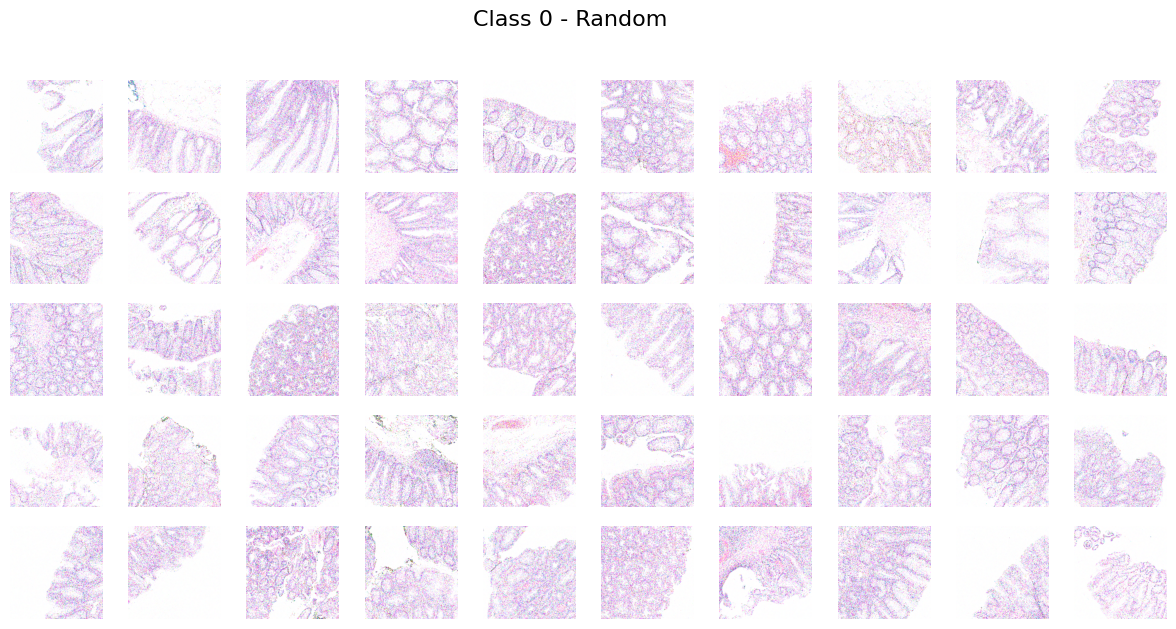

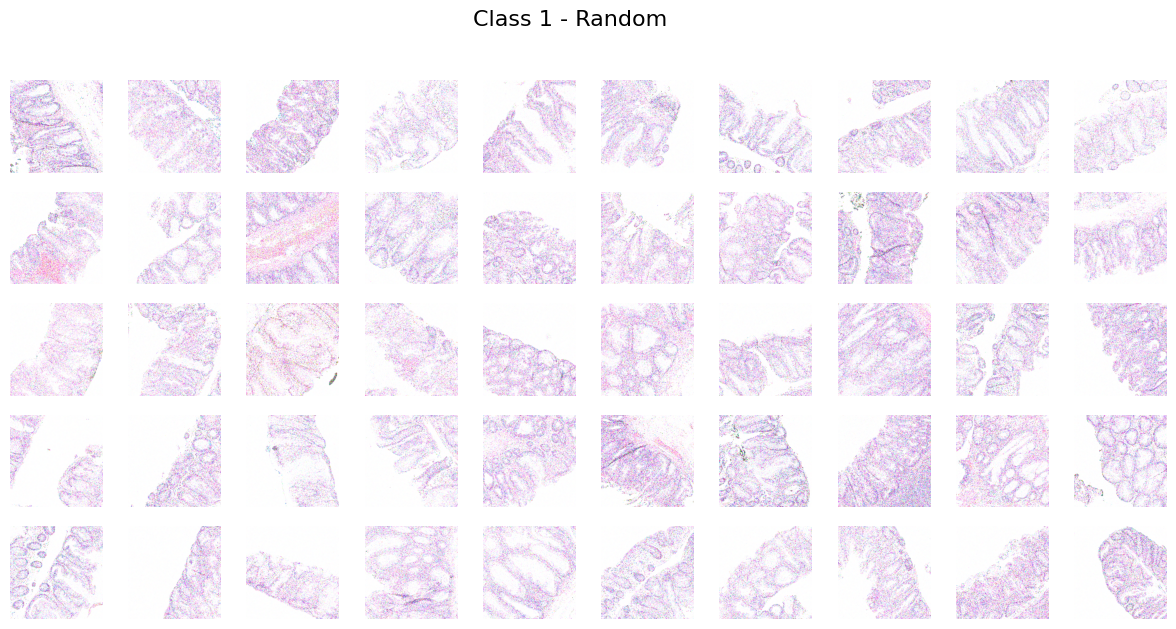

Image grids saved to mhist_result/Random_grid


In [92]:
img_syn_loaded = torch.load('mhist_result/Random_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

display_image_grid(img_syn, labels_syn, noise_type='Random')

In [67]:
# 2d
def generate_synthetic_dataset_with_noise(real_dataset, num_classes, images_per_class=50, K=200, eta_s=0.01,
                                          zeta_s=1, eta_theta=0.01, zeta_theta=50, minibatch_size=128, noise_std=0.8):
    synthetic_images = []
    synthetic_labels = []

    for class_id in range(num_classes):
        # Randomly sample 50 images from each class
        class_indices = [i for i, (_, label) in enumerate(real_dataset) if label == class_id]
        sampled_indices = random.sample(class_indices, images_per_class)

        for i in sampled_indices:
            noise = torch.normal(mean=0, std=noise_std, size=real_dataset[i][0].size())
            synthetic_image = real_dataset[i][0] + noise

            synthetic_image = torch.clamp(synthetic_image, 0, 1)

            synthetic_images.append(synthetic_image)
            synthetic_labels.append(real_dataset[i][1])


    img_syn = torch.stack(synthetic_images)
    labels_syn = torch.tensor(synthetic_labels, device=device)

    return img_syn, labels_syn

img_syn, labels_syn = generate_synthetic_dataset_with_noise(real_dataset, num_classes)
img_syn = torch.nn.Parameter(img_syn)
optimizer_img = optim.SGD([img_syn], lr=0.1)  # lr is eta_s

img_syn, labels_syn, losses = train_dataset(img_syn, labels_syn)
save_results(img_syn, labels_syn, losses, 'Gaussian')

Iteration 1/10
[2024-10-28 21:24:31] iter = 00000, loss = 0.0151
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
training completed.
Synthetic dataset saved to mhist_result/Gaussian_synthetic_dataset.pt
Training losses saved to mhist_result/Gaussian_training_losses.txt


<ipython-input-68-f0b648f49af3>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('mhist_result/Gaussian_synthetic_dataset.pt')


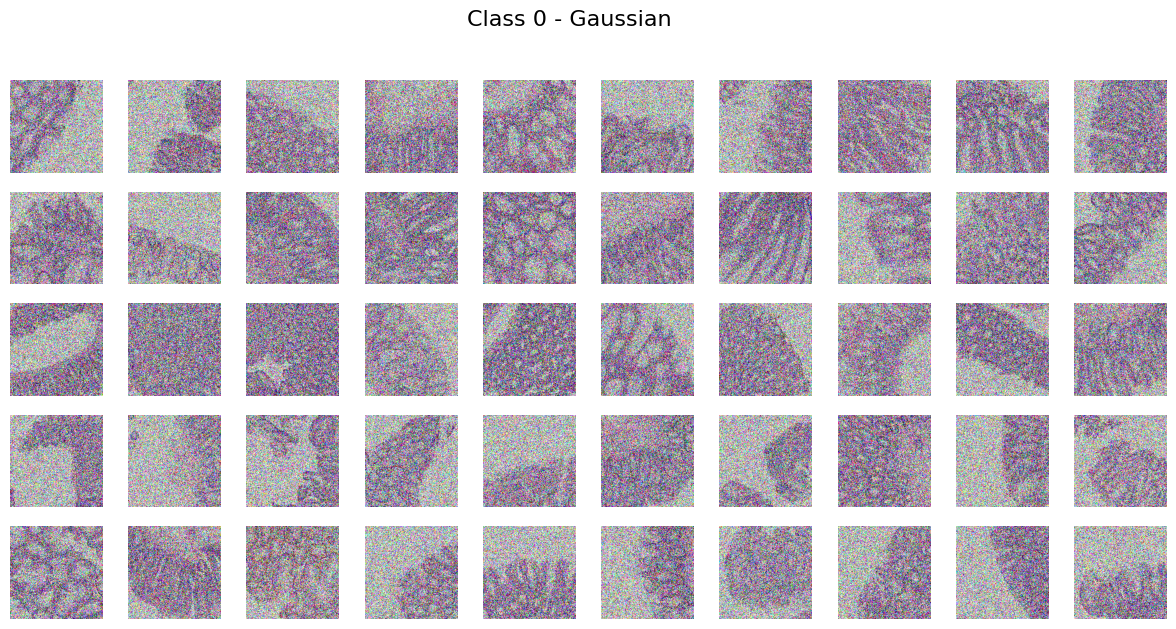

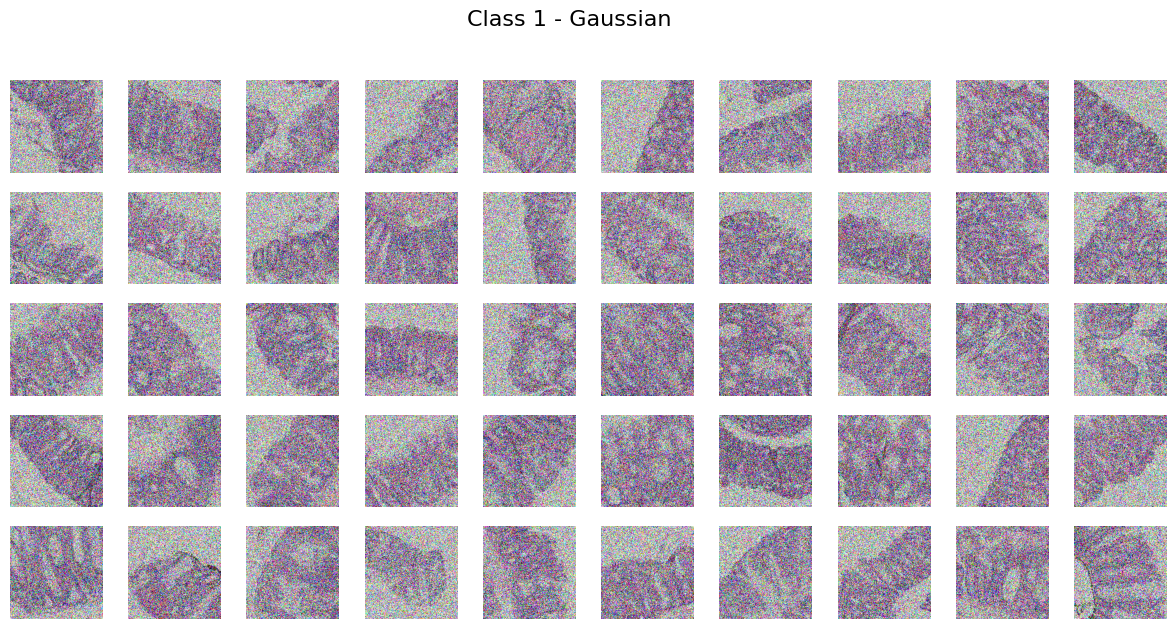

Image grids saved to mhist_result/Gaussian_grid


In [68]:
img_syn_loaded = torch.load('mhist_result/Gaussian_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

display_image_grid(img_syn, labels_syn, noise_type='Gaussian')

##### 2e) Train the model with condensed dataset

In [93]:
random_model = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224))
random_optimizer = SGD(random_model.parameters(), lr=0.01, momentum=0.9)

gaussian_model = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224))
gaussian_optimizer = SGD(gaussian_model.parameters(), lr=0.01, momentum=0.9)

random_scheduler = CosineAnnealingLR(random_optimizer, T_max=20)
gaussian_scheduler = CosineAnnealingLR(gaussian_optimizer, T_max=20)

random_criterion = torch.nn.CrossEntropyLoss()
gaussian_criterion = torch.nn.CrossEntropyLoss()

In [70]:
synthetic_model = get_network(model='ConvNetD7', channel=3, num_classes=2, im_size=(224, 224))
synthetic_optimizer = SGD(synthetic_model.parameters(), lr=0.01, momentum=0.9)

synthetic_scheduler = CosineAnnealingLR(synthetic_optimizer, T_max=20)

synthetic_criterion = torch.nn.CrossEntropyLoss()

In [71]:
img_syn_loaded = torch.load('mhist_result/_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

synthetic_synthetic_dataset = TensorDataset(img_syn, labels_syn)

synthetic_train_loader = DataLoader(synthetic_synthetic_dataset, batch_size=32, shuffle=True)

training_model(synthetic_model, synthetic_optimizer, synthetic_scheduler,
               synthetic_criterion, synthetic_train_loader)

<ipython-input-71-47ea8510e770>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('mhist_result/_synthetic_dataset.pt')


Epoch [1/20], Loss: 0.6860106301307678
Epoch [2/20], Loss: 0.5936785912513733
Epoch [3/20], Loss: 0.5799132585525513
Epoch [4/20], Loss: 0.49262181043624875
Epoch [5/20], Loss: 0.5024914789199829
Epoch [6/20], Loss: 0.40833731174468996
Epoch [7/20], Loss: 0.3991177439689636
Epoch [8/20], Loss: 0.2945234832167625
Epoch [9/20], Loss: 0.22941727742552756
Epoch [10/20], Loss: 0.18149369239807128
Epoch [11/20], Loss: 0.1346120923757553
Epoch [12/20], Loss: 0.11081783056259155
Epoch [13/20], Loss: 0.085139701962471
Epoch [14/20], Loss: 0.08724859148263932
Epoch [15/20], Loss: 0.08025107204914093
Epoch [16/20], Loss: 0.07024900555610657
Epoch [17/20], Loss: 0.06078611195087433
Epoch [18/20], Loss: 0.056082479655742645
Epoch [19/20], Loss: 0.0533547055721283
Epoch [20/20], Loss: 0.05197476208209992


In [94]:
from torch.utils.data import TensorDataset, DataLoader

img_syn_loaded = torch.load('mhist_result/Random_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

random_synthetic_dataset = TensorDataset(img_syn, labels_syn)

random_train_loader = DataLoader(random_synthetic_dataset, batch_size=32, shuffle=True)

training_model(random_model, random_optimizer, random_scheduler,
               random_criterion, random_train_loader)

<ipython-input-94-bc34fe09cb3a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('mhist_result/Random_synthetic_dataset.pt')


Epoch [1/20], Loss: 0.6921545958518982
Epoch [2/20], Loss: 0.6388148903846741
Epoch [3/20], Loss: 0.6454424619674682
Epoch [4/20], Loss: 0.5807123064994812
Epoch [5/20], Loss: 0.5542330813407897
Epoch [6/20], Loss: 0.4966092872619629
Epoch [7/20], Loss: 0.4906041359901428
Epoch [8/20], Loss: 0.39121569275856016
Epoch [9/20], Loss: 0.3937921416759491
Epoch [10/20], Loss: 0.3142615985870361
Epoch [11/20], Loss: 0.29218512654304507
Epoch [12/20], Loss: 0.23128241062164306
Epoch [13/20], Loss: 0.18372708559036255
Epoch [14/20], Loss: 0.15876151084899903
Epoch [15/20], Loss: 0.12777917504310607
Epoch [16/20], Loss: 0.11556254208087921
Epoch [17/20], Loss: 0.10571771740913391
Epoch [18/20], Loss: 0.09875563740730285
Epoch [19/20], Loss: 0.09486180126667022
Epoch [20/20], Loss: 0.09297419279813766


In [73]:

img_syn_loaded = torch.load('mhist_result/Gaussian_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

gaussian_synthetic_dataset = TensorDataset(img_syn, labels_syn)

gaussian_train_loader = DataLoader(gaussian_synthetic_dataset, batch_size=32, shuffle=True)

training_model(gaussian_model, gaussian_optimizer, gaussian_scheduler,
               gaussian_criterion, gaussian_train_loader)

<ipython-input-73-7f9183b8d961>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('mhist_result/Gaussian_synthetic_dataset.pt')


Epoch [1/20], Loss: 0.6850392150878907
Epoch [2/20], Loss: 0.649034035205841
Epoch [3/20], Loss: 0.6319381070137023
Epoch [4/20], Loss: 0.5878143000602722
Epoch [5/20], Loss: 0.556275624036789
Epoch [6/20], Loss: 0.5327962875366211
Epoch [7/20], Loss: 0.45122406125068665
Epoch [8/20], Loss: 0.4178493881225586
Epoch [9/20], Loss: 0.39447555899620057
Epoch [10/20], Loss: 0.353438184261322
Epoch [11/20], Loss: 0.2607522296905518
Epoch [12/20], Loss: 0.20092736124992372
Epoch [13/20], Loss: 0.17175554871559143
Epoch [14/20], Loss: 0.1390705418586731
Epoch [15/20], Loss: 0.10193226754665374
Epoch [16/20], Loss: 0.07801055744290351
Epoch [17/20], Loss: 0.06292145520448685
Epoch [18/20], Loss: 0.056475188434123996
Epoch [19/20], Loss: 0.05164927802979946
Epoch [20/20], Loss: 0.04985559329390526


In [95]:
test_folder = 'mhist_dataset/test'

transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [75]:
evaluate_model(synthetic_model, test_loader)

Test Accuracy: 57.32%


In [96]:
evaluate_model(gaussian_model, test_loader)

Test Accuracy: 56.19%


In [77]:
evaluate_model(random_model, test_loader)

Test Accuracy: 52.20%


#### 3 Cross-Architecture Generalization

In [78]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, norm='instancenorm'):
        super(BasicBlock, self).__init__()
        self.norm = norm
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.GroupNorm(planes, planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(self.expansion*planes, self.expansion*planes, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, channel=3, num_classes=10, norm='instancenorm'):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.norm = norm

        self.conv1 = nn.Conv2d(channel, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.GroupNorm(64, 64, affine=True) if self.norm == 'instancenorm' else nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.classifier = nn.Linear(512 * 7 * 7, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.norm))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def embed(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out

def ResNet18(channel, num_classes):
    return ResNet(BasicBlock, [2,2,2,2], channel=channel, num_classes=num_classes)

In [97]:
random_resnet = ResNet18(channel=3, num_classes=2)
random_optimizer = SGD(random_resnet.parameters(), lr=0.01, momentum=0.9)
random_resnet.to(device)

gaussian_resnet = ResNet18(channel=3, num_classes=2)
gaussian_optimizer = SGD(gaussian_resnet.parameters(), lr=0.01, momentum=0.9)
gaussian_resnet.to(device)

random_scheduler = CosineAnnealingLR(random_optimizer, T_max=20)
gaussian_scheduler = CosineAnnealingLR(gaussian_optimizer, T_max=20)

random_criterion = torch.nn.CrossEntropyLoss()
gaussian_criterion = torch.nn.CrossEntropyLoss()

In [80]:
synthetic_model = ResNet18(channel=3, num_classes=2)
synthetic_optimizer = SGD(synthetic_model.parameters(), lr=0.01, momentum=0.9)

synthetic_scheduler = CosineAnnealingLR(synthetic_optimizer, T_max=20)

synthetic_criterion = torch.nn.CrossEntropyLoss()

In [98]:
img_syn_loaded = torch.load('mhist_result/Random_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

random_synthetic_dataset = TensorDataset(img_syn, labels_syn)

random_train_loader = DataLoader(random_synthetic_dataset, batch_size=32, shuffle=True)

training_model(random_resnet, random_optimizer, random_scheduler,
               random_criterion, random_train_loader)

<ipython-input-98-aed1acfc7221>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('mhist_result/Random_synthetic_dataset.pt')


Epoch [1/20], Loss: 13.044464664459229
Epoch [2/20], Loss: 20.391090965270998
Epoch [3/20], Loss: 9.214661560058595
Epoch [4/20], Loss: 16.974228897094726
Epoch [5/20], Loss: 11.889850463867187
Epoch [6/20], Loss: 12.893103904724121
Epoch [7/20], Loss: 8.268379970586393
Epoch [8/20], Loss: 6.01524871630536
Epoch [9/20], Loss: 3.710062012672424
Epoch [10/20], Loss: 3.450547342300415
Epoch [11/20], Loss: 2.0573684692382814
Epoch [12/20], Loss: 1.700845181941986
Epoch [13/20], Loss: 3.031704750061035
Epoch [14/20], Loss: 1.7956063079833984
Epoch [15/20], Loss: 0.9973782920837402
Epoch [16/20], Loss: 0.5631664797663689
Epoch [17/20], Loss: 0.6083517086174106
Epoch [18/20], Loss: 0.43784032851457594
Epoch [19/20], Loss: 0.4395829367637634
Epoch [20/20], Loss: 0.405109281539917


In [84]:
img_syn_loaded = torch.load('mhist_result/_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

synthetic_dataset = TensorDataset(img_syn, labels_syn)

train_loader = DataLoader(synthetic_dataset, batch_size=32, shuffle=True)

training_model(synthetic_model, synthetic_optimizer, synthetic_scheduler,
               synthetic_criterion, train_loader)

<ipython-input-84-d702958738aa>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('mhist_result/_synthetic_dataset.pt')


Epoch [1/20], Loss: 41.04051286697388
Epoch [2/20], Loss: 50.714676971435544
Epoch [3/20], Loss: 32.96036087036133
Epoch [4/20], Loss: 21.687471389770508
Epoch [5/20], Loss: 6.876228189468383
Epoch [6/20], Loss: 7.498231620788574
Epoch [7/20], Loss: 5.532790908813476
Epoch [8/20], Loss: 4.709435957670212
Epoch [9/20], Loss: 6.38412732064724
Epoch [10/20], Loss: 3.2741936874389648
Epoch [11/20], Loss: 2.6681489658355715
Epoch [12/20], Loss: 1.615774278640747
Epoch [13/20], Loss: 1.0449660420417786
Epoch [14/20], Loss: 0.983213957156986
Epoch [15/20], Loss: 1.020896854400471
Epoch [16/20], Loss: 0.9514946535229682
Epoch [17/20], Loss: 0.8478076457977295
Epoch [18/20], Loss: 0.7639655270427466
Epoch [19/20], Loss: 0.706576624289155
Epoch [20/20], Loss: 0.6920673999190331


In [82]:
img_syn_loaded = torch.load('mhist_result/Gaussian_synthetic_dataset.pt')
img_syn = img_syn_loaded['images']
labels_syn = img_syn_loaded['labels']

gaussian_synthetic_dataset = TensorDataset(img_syn, labels_syn)

gaussian_train_loader = DataLoader(gaussian_synthetic_dataset, batch_size=32, shuffle=True)

training_model(gaussian_resnet, gaussian_optimizer, gaussian_scheduler,
               gaussian_criterion, gaussian_train_loader)

<ipython-input-82-d4ccb66b2930>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img_syn_loaded = torch.load('mhist_result/Gaussian_synthetic_dataset.pt')


Epoch [1/20], Loss: 30.35988344192505
Epoch [2/20], Loss: 53.777925186157226
Epoch [3/20], Loss: 106.92907104492187
Epoch [4/20], Loss: 28.417549438476563
Epoch [5/20], Loss: 21.625013427734373
Epoch [6/20], Loss: 11.649683569669655
Epoch [7/20], Loss: 4.792822585105896
Epoch [8/20], Loss: 2.3894866514205932
Epoch [9/20], Loss: 2.3777444839477537
Epoch [10/20], Loss: 1.9669443321228028
Epoch [11/20], Loss: 1.088981227874756
Epoch [12/20], Loss: 1.4156518077850342
Epoch [13/20], Loss: 1.5027015772927552
Epoch [14/20], Loss: 1.4025748423486948
Epoch [15/20], Loss: 0.8511455242350349
Epoch [16/20], Loss: 0.6260619497299195
Epoch [17/20], Loss: 0.5313260945677757
Epoch [18/20], Loss: 0.4894945251941681
Epoch [19/20], Loss: 0.435772748173913
Epoch [20/20], Loss: 0.4053102886676788


In [99]:
test_folder = 'mhist_dataset/test'

transform = transforms.Compose([
    transforms.ToTensor()
])

test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [85]:
evaluate_model(synthetic_model, test_loader)

Test Accuracy: 52.92%


In [87]:
evaluate_model(gaussian_resnet, test_loader)

Test Accuracy: 51.79%


In [100]:
evaluate_model(random_resnet, test_loader)

Test Accuracy: 49.85%
